In [331]:
from matplotlib import pyplot as plt
import numpy as np
from fpl import FPL
import aiohttp
import asyncio
import pandas as pd
from random import shuffle
from collections import defaultdict
!pip install scipy
from scipy.stats import skewnorm
print("hello FPL")

     |████████████████████████████████| 25.9 MB 27 kB/s 
hello FPL


### Get 50 players with highest value per dollar and see what happens

In [102]:
async def get_value_data():
    data = pd.DataFrame(columns=['Name', 'position', 'points_per_game', 'minutes', 'now_cost', 'value'])
    position_map = {
        1: "Goalkeeper",
        2: "Defender",
        3: "Midfielder",
        4: "Forward"
    }
    async with aiohttp.ClientSession() as session:
        fpl = FPL(session)
        for i in range(1, 498):
            try :
                player = await fpl.get_player(i)
                value = float(player.points_per_game) / float(player.now_cost)
                name = player.first_name + " " + player.second_name
                data.loc[i] = [name, position_map[player.element_type], float(player.points_per_game), float(player.minutes), float(player.now_cost), float(value)]
            except ValueError:
                print(f"player not found {i}")
    data.sort_values(by = ['value'], inplace = True, ascending = False)
    return data
    
    
value_data = await get_value_data()
value_data.head()

,Name,position,points_per_game,minutes,now_cost,value
240,Luke Thomas,Defender,5.0,267.0,45.0,0.111111
429,David Martin,Goalkeeper,4.0,435.0,40.0,0.100000
104,Marcos Alonso,Defender,5.6,1429.0,60.0,0.093333
327,Florian Lejeune,Defender,4.0,440.0,45.0,0.088889
10,Pablo Marí,Defender,4.0,113.0,45.0,0.088889


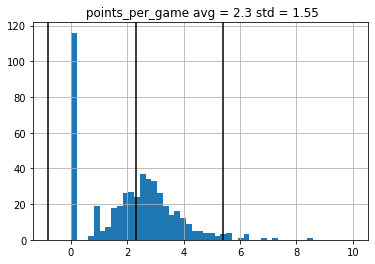

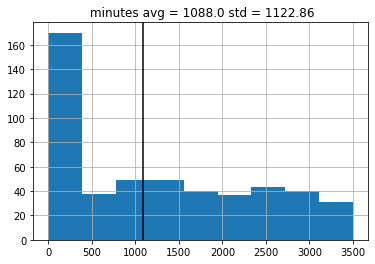

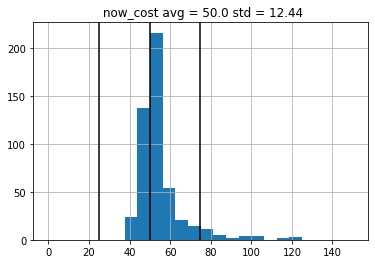

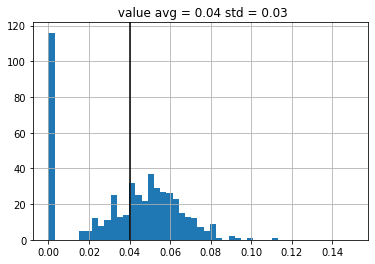

(0.04, 0.03)

In [103]:
def visualize_distribution(data, column, bins, normal  = True):
    median = round(data[column].median(), 2)
    std = round(data[column].std(), 2)
    data[column].hist(bins = bins)
    plt.axvline(median, color = 'black')
    if normal:
        plt.axvline(median - 2 * std, color = 'black')
        plt.axvline(median + 2 * std, color = 'black')
    plt.title(f" {column} avg = {median} std = {std}")
    plt.show()
    return median, std

visualize_distribution(value_data, 'points_per_game', bins = np.linspace(0, 10, 50))
visualize_distribution(value_data, 'minutes', bins = np.linspace(0, 3500, 10), normal = False)
visualize_distribution(value_data, 'now_cost', bins = np.linspace(0, 150, 25))
visualize_distribution(value_data, 'value', bins = np.linspace(0, 0.15, 50), normal = False)

In [469]:
def greedy_random_soft(data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length, minute_threshold = 1000, a = -1, loc = 0.3, scale = 0.1):
    data = data[data['minutes'] >minute_threshold]
    data['normalized_points_per_game'] = (data['points_per_game'] - data['points_per_game'].mean() )/ data['points_per_game'].std()
    data['normalized_value'] =  (data['value'] - data['value'].mean() )/ data['value'].std()
    soft_scores = skewnorm.rvs(a = a, loc=loc, scale = scale, size=(15, ))
    soft_scores = sorted(soft_scores, reverse=True)
    players_selected = pd.DataFrame(columns=['Name', 'position', 'points_per_game', 'minutes', 'now_cost', 'value'])
    choices = ["Forward"] * num_forwards + ["Midfielder"] * num_midfielders + ["Defender"] * num_defenders + ["Goalkeeper"] * num_goalkeepers
    total_cost = 0
    shuffle(choices)
    for i, soft_score in enumerate(soft_scores):
        choice = choices.pop()
        choice_data = data[(data['position'] == choice) & (data['now_cost'] + total_cost < budget)]
        if not choice_data.shape[0]:
            print("Budget error")
            return pd.DataFrame()
        choice_data['soft_score'] = soft_score * choice_data['normalized_points_per_game'] + (1 - soft_score) * choice_data['normalized_value']
        choice_data.sort_values(by=['soft_score'], inplace = True, ascending = False)
        player_selected = choice_data.iloc[0]
        players_selected.loc[i] = player_selected
        total_cost += player_selected["now_cost"]
        data = data[data["Name"] != player_selected["Name"]]
    players_selected.sort_values(by=['position'], inplace = True)
    return players_selected

def greedy_random_with_superstar(data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length, num_superstars = 2, superstar_search_width = 25, superstar_minute_threshold = 2000):
    superstar_data = data[data['minutes'] > superstar_minute_threshold]
    superstar_data.sort_values(by='points_per_game', ascending = False, inplace=True)
    superstar_data = superstar_data.head(superstar_search_width)
    superstars = superstar_data.sample(num_superstars)
    value_players_data = data[~(data["Name"].isin(superstars["Name"]))]
    for _, superstar in superstars.iterrows():
        if superstar.position == "Forward": num_forwards -= 1
        elif superstar.position == "Midfielder": num_midfielders -= 1
        elif superstar.position == "GoalKeeper": num_goalkeepers -= 1
        budget -= superstar.now_cost
        squad_length -= 1

    value_players = greedy_random(data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length)
    if value_players.shape[0] == 0:
        return pd.DataFrame()
    players_selected = pd.concat((superstars, value_players))
    players_selected.sort_values(by=['position'], inplace = True)
    return players_selected
    

def greedy_random(data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length, search_width = 5):
    expected_points = 0
    players_selected = pd.DataFrame(columns=['Name', 'position', 'points_per_game', 'minutes', 'now_cost', 'value'])
    choices = ["Forward"] * num_forwards + ["Midfielder"] * num_midfielders + ["Defender"] * num_defenders + ["Goalkeeper"] * num_goalkeepers
    total_cost = 0
    shuffle(choices)
    for i in range(squad_length):
        choice = choices.pop()
        choice_data = data[(data['position'] == choice) & (data['now_cost'] + total_cost < budget)]
        if not choice_data.shape[0]:
            print("Budget error")
            return pd.DataFrame()
        choice_data.sort_values(by=['value'], inplace = True, ascending = False)
        player_selected = choice_data.head(search_width).iloc[np.random.randint(search_width)]
        players_selected.loc[i] = player_selected
        total_cost += player_selected["now_cost"]
        data = data[data["Name"] != player_selected["Name"]]
        
    players_selected.sort_values(by=['position'], inplace = True)
    return players_selected
        

def get_valuable_players(value_data, minute_threshold = 1000, num_forwards = 3, num_midfielders = 5, num_defenders = 5, num_goalkeepers = 2, budget = 1000, squad_length = 15, policy = 'greedy_random'):
    value_data = value_data[value_data["minutes"] > minute_threshold]
    policy_map = { "greedy_random" : greedy_random, "greedy_random_soft" : greedy_random_soft, "greedy_random_with_superstar" : greedy_random_with_superstar}
    policy = policy_map[policy]
    return policy(value_data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length)

best_squad = None
best_expected_points = -np.inf

results = defaultdict(lambda : defaultdict(list))
for _ in range(50):
    for policy in ['greedy_random',  'greedy_random_with_superstar', 'greedy_random_soft']:
        squad = get_valuable_players(value_data, policy = policy)
        if not squad.shape[0]:
            points, cost = 0, np.inf
            continue
        else:    
            points, cost = squad['points_per_game'].sum(), squad['now_cost'].sum()
        if points > best_expected_points:
            best_squad = squad
            best_expected_points = points
        results[policy]['expected_points_per_game'].append(points)
        results[policy]['expected_cost'].append(cost)

print(best_expected_points)
best_squad

Budget error
Budget error
Budget error
Budget error
Budget error
Budget error
Budget error
Budget error
Budget error
Budget error
Budget error
Budget error
Budget error
Budget error
Budget error
74.80000000000001


,Name,position,points_per_game,minutes,now_cost,value
1,Marcos Alonso,Defender,5.6,1429.0,60.0,0.093333
3,Willy Boly,Defender,4.4,1980.0,55.0,0.080000
6,Phil Bardsley,Defender,3.7,1890.0,45.0,0.082222
7,Trent Alexander-Arnold,Defender,5.5,3173.0,75.0,0.073333
14,Charlie Taylor,Defender,3.5,1944.0,45.0,0.077778
4,Anthony Martial,Forward,6.2,2625.0,90.0,0.068889
10,Michail Antonio,Forward,4.6,1767.0,65.0,0.070769
13,Chris Wood,Forward,4.2,2436.0,65.0,0.064615
11,Hugo Lloris,Goalkeeper,4.7,1808.0,55.0,0.085455
12,Nick Pope,Goalkeeper,4.5,3420.0,55.0,0.081818


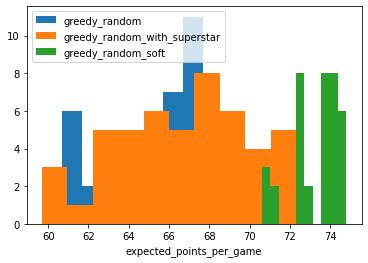

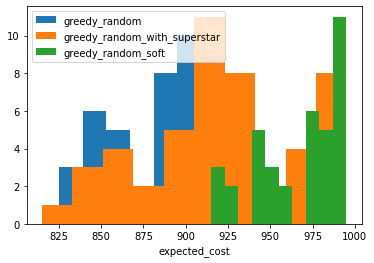

In [470]:
def visualize_results(results, metric):
    for policy in ['greedy_random',  'greedy_random_with_superstar', 'greedy_random_soft']:
        plt.hist(results[policy][metric], label = policy)
        plt.xlabel(metric)
    plt.legend(loc='upper left')
    plt.show()
visualize_results(results, "expected_points_per_game")
visualize_results(results, "expected_cost")